In [ ]:
from google.colab import files

uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from imblearn.over_sampling import SMOTE


In [ ]:
# Load the dataset
data = pd.read_csv('creditcard.csv')

# Display first few rows to understand the structure
print(data.head())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

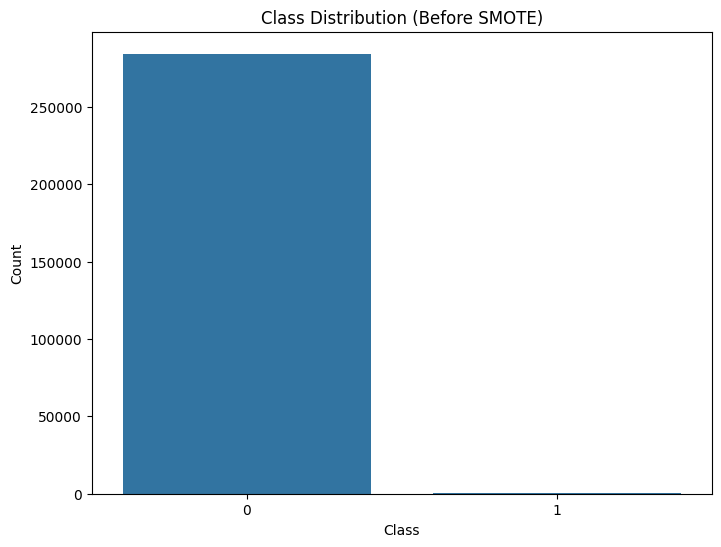

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=data)
plt.title('Class Distribution (Before SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [ ]:
scaler_time = StandardScaler()
data['Time'] = scaler_time.fit_transform(data['Time'].values.reshape(-1, 1))

# Log transformation of 'Amount' to reduce skewness
data['Amount'] = np.log1p(data['Amount'])

# Scale 'Amount' using RobustScaler
scaler_amount = RobustScaler()
data['Amount'] = scaler_amount.fit_transform(data['Amount'].values.reshape(-1, 1))


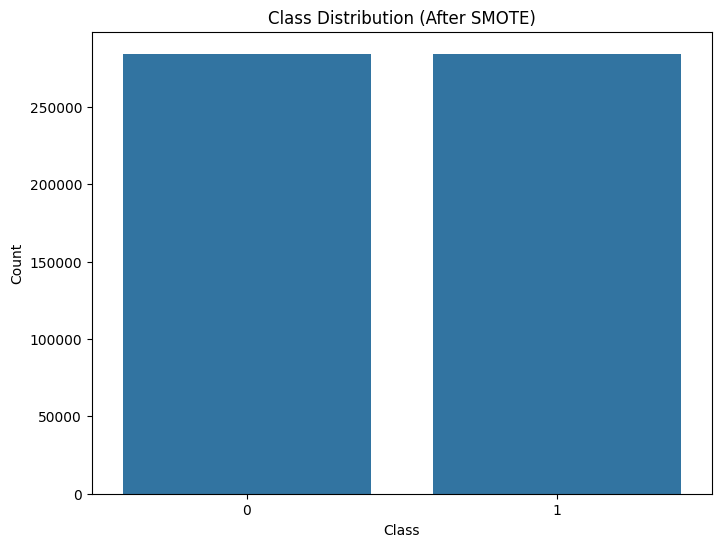

In [ ]:
X = data.drop('Class', axis=1)
y = data['Class']

# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Visualize the class distribution after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled)
plt.title('Class Distribution (After SMOTE)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [ ]:
# Split data into training and testing sets (80% train, 20% test)
X_train_res, X_val_res, y_train_res, y_val_res = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5)
grid_search.fit(X_train_res, y_train_res)

# Display the best parameters found
print("Best parameters found:", grid_search.best_params_)


Best parameters found: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
log_reg = grid_search.best_estimator_

# Fit the model on the training data
log_reg.fit(X_train_res, y_train_res)

# Predict on the validation set
y_val_pred = log_reg.predict(X_val_res)


In [ ]:
accuracy = accuracy_score(y_val_res, y_val_pred)
class_report = classification_report(y_val_res, y_val_pred)
conf_matrix = confusion_matrix(y_val_res, y_val_pred)

# Print results
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{class_report}")
print(f"Confusion Matrix:\n{conf_matrix}")


Accuracy: 0.9476636828869388
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     56863
           1       0.97      0.92      0.95     56863

    accuracy                           0.95    113726
   macro avg       0.95      0.95      0.95    113726
weighted avg       0.95      0.95      0.95    113726

Confusion Matrix:
[[55473  1390]
 [ 4562 52301]]


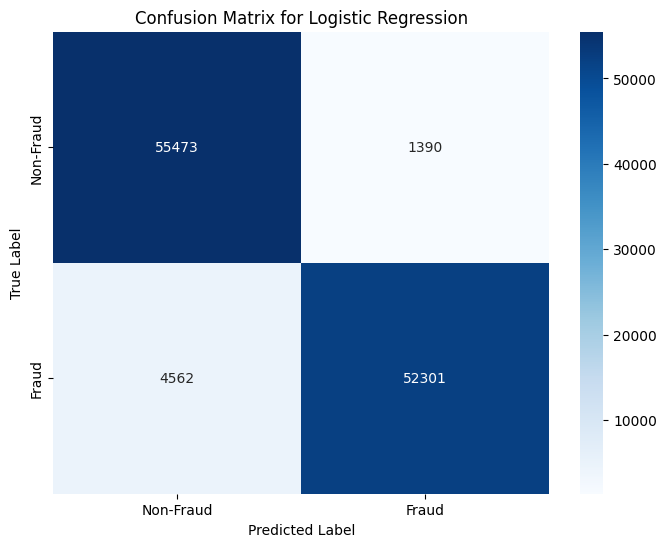

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


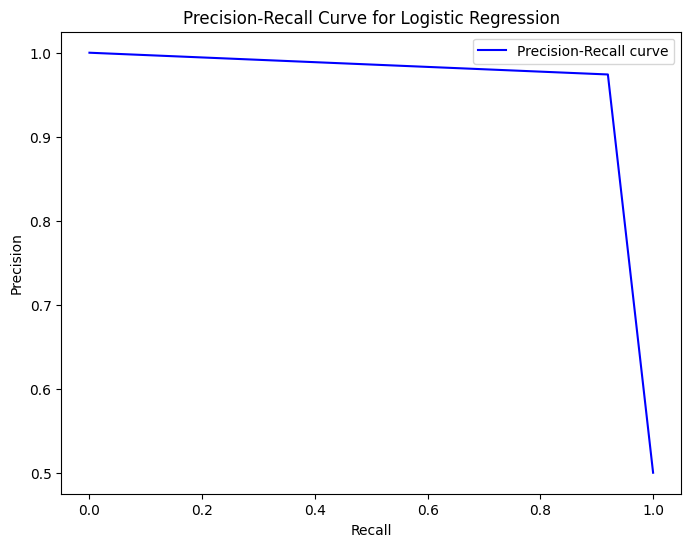

In [ ]:
precision, recall, _ = precision_recall_curve(y_val_res, y_val_pred)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.legend()
plt.show()


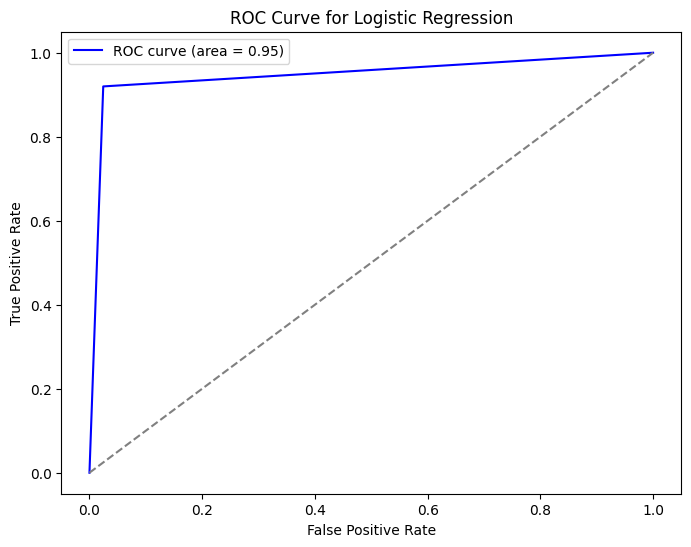

In [ ]:
fpr, tpr, _ = roc_curve(y_val_res, y_val_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend()
plt.show()


In [ ]:
cv_scores = cross_val_score(log_reg, X_train_res, y_train_res, cv=5)

# Display cross-validation scores and their average
print("Cross-validation scores:", cv_scores)
print("Average cross-validation score:", cv_scores.mean())


Cross-validation scores: [0.94574691 0.9472857  0.94819798 0.94752751 0.94687843]
Average cross-validation score: 0.9471273054339584


In [ ]:
cv_scores = cross_val_score(log_reg, X_train_res, y_train_res, cv=5)

# Display cross-validation scores and their average
print("Cross-validation scores:", cv_scores)
print("Average cross-validation score:", cv_scores.mean())


Cross-validation scores: [0.94574691 0.9472857  0.94819798 0.94752751 0.94687843]
Average cross-validation score: 0.9471273054339584


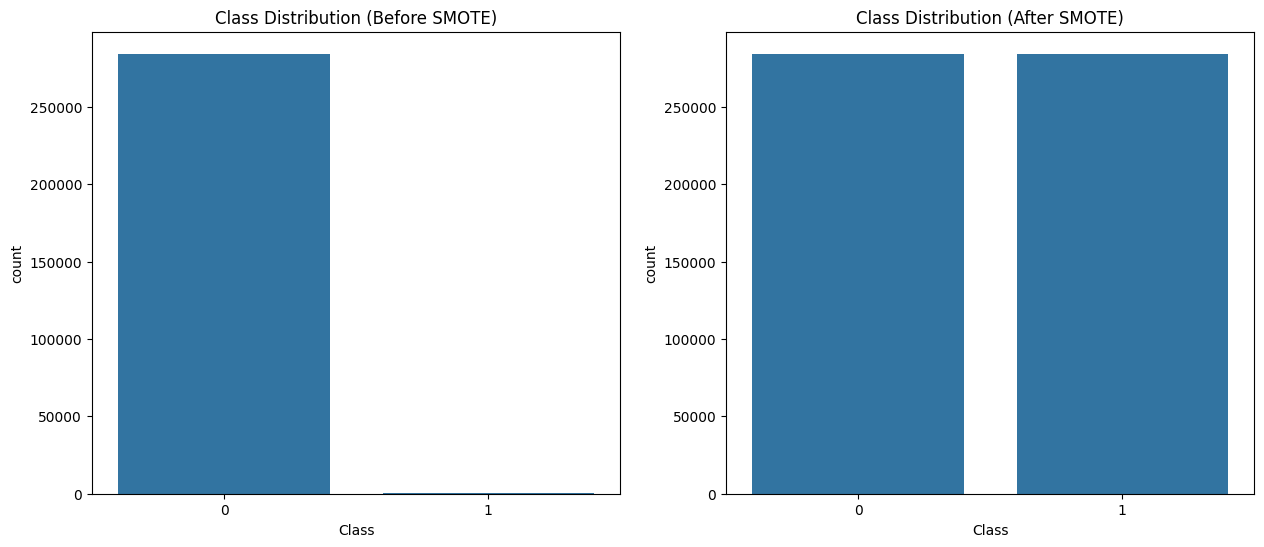

In [ ]:
# Plot class distribution before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(x=y, ax=axes[0])
axes[0].set_title('Class Distribution (Before SMOTE)')

sns.countplot(x=y_resampled, ax=axes[1])
axes[1].set_title('Class Distribution (After SMOTE)')

plt.show()


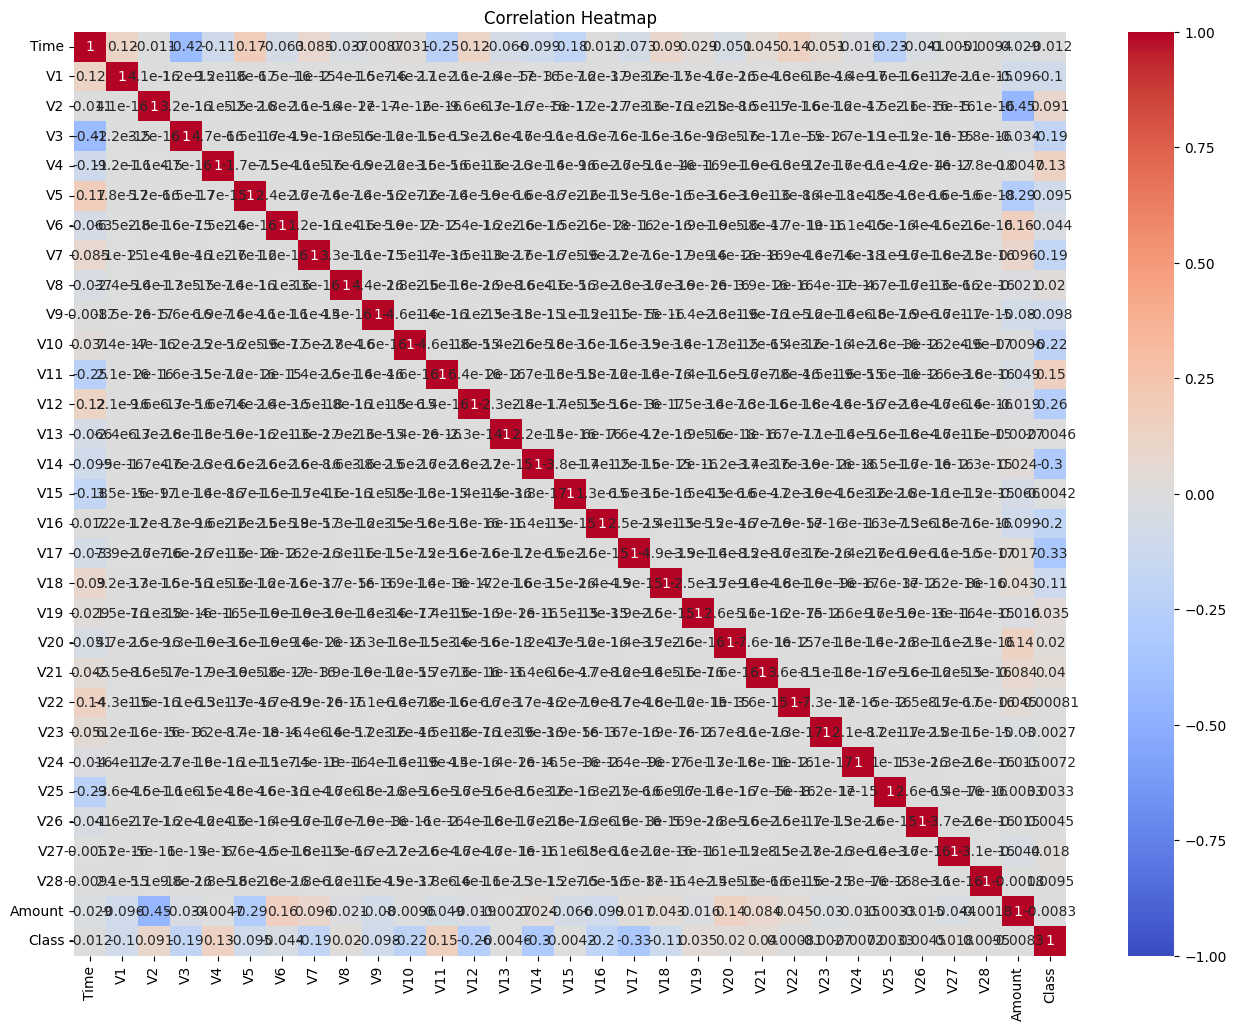

In [ ]:
correlation_matrix = data.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


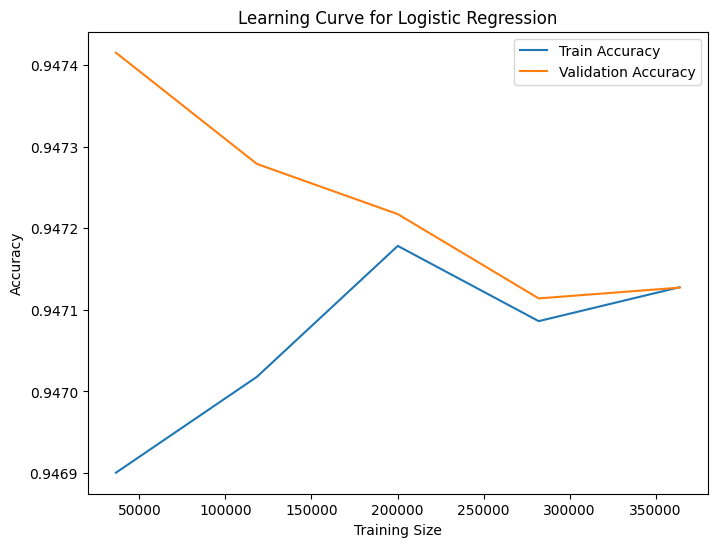

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(log_reg, X_train_res, y_train_res, cv=5, scoring='accuracy')

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train Accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Accuracy')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Logistic Regression')
plt.legend()
plt.show()
